In [1]:
# https://keras.io/examples/vision/segformer/

In [2]:
# import the packages we need...
#first, the general stuff
#load up the basics
import os, pathlib, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.8.0
 GPU: /device:GPU:0


In [3]:
#data pipeline
auto = tf.data.AUTOTUNE
num_classes = 4

def load_data(path, val_split = 0.2):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "labels/*")))
    
    data = list(zip(images,masks))
    random.shuffle(data)
    
    split_index = int(len(data)*(1-val_split))
    train_data = data[:split_index]
    val_data = data[split_index:]
    
    train_images, train_labels = zip(*train_data)
    val_images, val_labels = zip(*val_data)

    return train_images, train_labels, val_images, val_labels

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

#standardization of images using adjusted standard deviation

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img)==2:
        img = np.dstack((img,img,img))

    return img

# custom 2d resizing functions for 2d discrete labels
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows
    nC0 = len(im[0])  # source number of columns
    tmp = [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]
            for c in range(nC)] for r in range(nR)]
    return np.array(tmp).reshape((nR,nC))

#reading the image
def read_image(path):
    x = imread(path)
    x = resize(x, (512,512), anti_aliasing=False)
    x = standardize(x)
    x = x.astype(np.float32)
    return x

#reading the labels
def read_mask(path):
    y = imread(path)
    y = scale(y,512,512)

    y = D_Filter(y)
    y = y.astype(np.int32)
    
    #Label encoding
    y = np.expand_dims(y, axis=-1)

    # one hot encoding
    #y = np.eye(num_classes)[y]
    #y = y.astype(np.int32)
        
    return y

#the preprocessing code for images and labels
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    #images.set_shape([512, 512,3])
    
    images = tf.transpose(images, (2, 0, 1))
    images.set_shape([3, 512, 512])
    
    #LABEL
    masks.set_shape([512, 512])
    #one hot
    #masks.set_shape([512, 512, num_classes])
    

    return {"pixel_values": images, "labels": tf.squeeze(masks)}


#function to make a tf dataset object
def make_tfdataset(x, y, BATCH_SIZE = 4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess , num_parallel_calls = auto)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE) #, drop_remainder=True)
    dataset = dataset.prefetch(auto)

    return dataset


In [4]:
# make the dataset
path = ("data/")
val_split = 0.2
batch = 4


train_images, train_labels, val_images, val_labels = load_data(path, val_split)

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Val Images: {len(val_images)}, Val Labels: {len(val_labels)}")


train_dataset = make_tfdataset(list(train_images), list(train_labels), batch)
val_dataset = make_tfdataset(list(val_images), list(val_labels), batch)


print(train_dataset.element_spec)
print(val_dataset.element_spec)

Train Images: 812, Train Labels: 812
Val Images: 203, Val Labels: 203
{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int32, name=None)}
{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int32, name=None)}


In [5]:
image_count = 1015
batch_count = image_count/batch

val_size = int(batch_count * 0.2)
steps_per_epoch = int(len(train_images)/batch)
validation_steps = int(len(val_images)/batch)
print(steps_per_epoch)
print(validation_steps)

203
50


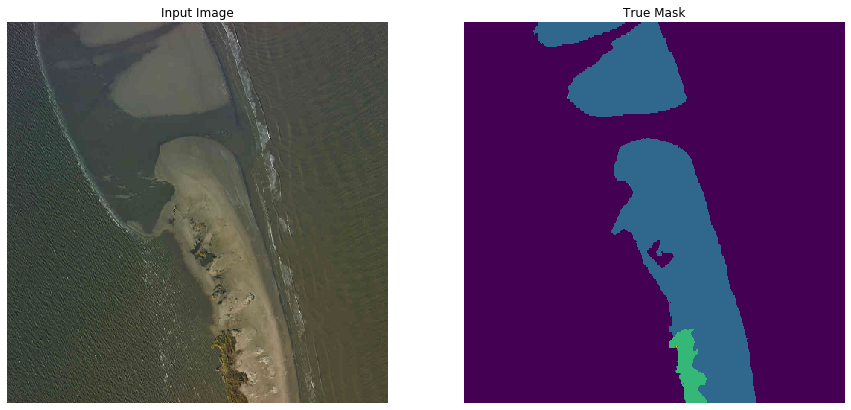

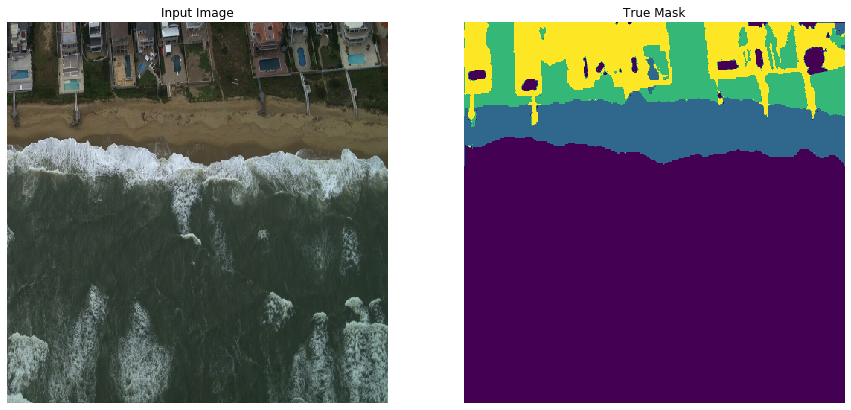

In [6]:
# plot results

#this function works for label encoding, not One hopt encoding
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for samples in train_dataset.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    #print(sample_image)
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])


In [7]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"

id2label = {0: "water", 1: "sand", 2: "veg",3: "dev"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)


No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [9]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


In [10]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 396292    
 odeHead)                                                        
                                                                 
Total params: 3,715,684
Trainable params: 3,715,172
Non-trainable params: 512
_________________________________________________________________


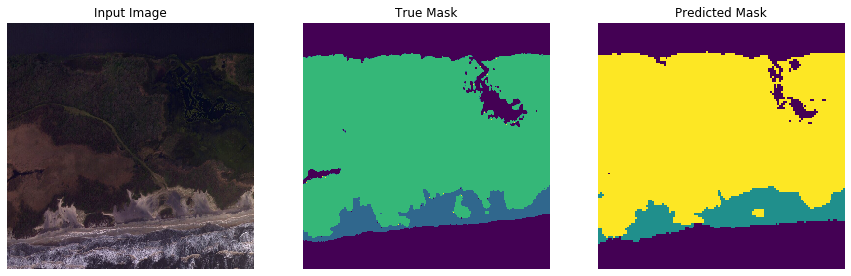


Sample Prediction after epoch 5

203/203 [==============================] - 165s 816ms/step - loss: 0.2254 - val_loss: 0.2651


In [13]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 5

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[DisplayCallback(val_dataset)],
    steps_per_epoch = steps_per_epoch,
    validation_steps =  val_size ,
    epochs=epochs,
)

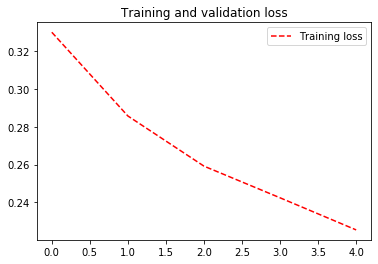

<Figure size 432x288 with 0 Axes>

In [15]:
#now that training is done, lets look at the metrics from training
%matplotlib inline

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r--', label='Training loss')
#plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

# # if you have another metric... i.e.,accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()


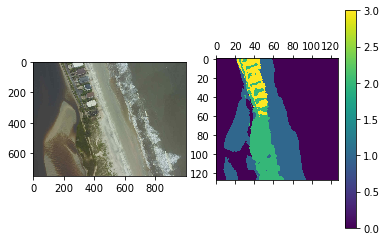

In [33]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = 'data/images/C26047791-1_EBG.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = (512,512))
img = tf.keras.preprocessing.image.img_to_array(img)
img = standardize(img)
img = tf.transpose(img, (2, 0, 1))
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img).logits
pred = tf.math.argmax(pred, axis=1)
lab = pred[0]


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgUP)
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# water: 0; sand:1; veg : 2; dev : 3